## Importing Libraries

In [213]:
import pandas as pd
import numpy as np
import seaborn as sns
import pylab
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt

## Constant Declaration

## Classes

In [214]:
class FeatureAnalysis:
    
    def unique_values(self, df, feature_name):
        feature_values = df[feature_name].unique()
        feature_values.sort()
        return feature_values
    
    def draw_feature_plots(self, df, feature_name, target_name, is_categorical):
        feature = df[feature_name]
        fig, axs = plt.subplots(2, 2)
        fig.suptitle(f'"{feature_name}" feature analysis')

        axs[0, 0].hist(feature)
        
        if (is_categorical == False):
            axs[0, 1].boxplot(feature)
    
        stats.probplot(df[feature_name], dist='norm', plot=axs[1, 0])
        axs[1, 1].scatter(feature, df[target_name])

        plt.show()
    

## Loading training set

In [215]:
train_df = pd.read_csv('../datasets/house_prices/train.csv')
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [216]:
print('Number of FEATURES = ' + str(len(train_df.columns)))
print('Number of ROWS = ' + str(len(train_df)))
train_df.columns

Number of FEATURES = 81
Number of ROWS = 1460


Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [217]:
fa = FeatureAnalysis()

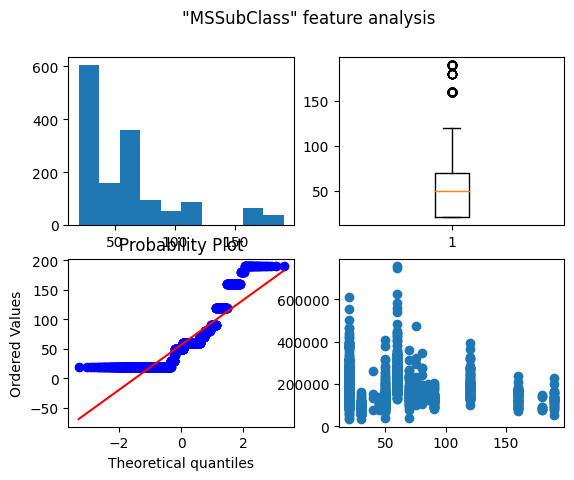

In [235]:
fa.draw_feature_plots(train_df, 'MSSubClass', 'SalePrice', False)
#stats.probplot(train_df['MSSubClass'], dist='norm', plot=plt)
#plt.show()

In [219]:
##values = fa.unique_values(train_df, 'MSSubClass')
##missing = train_df.isnull().mean().loc[lambda x : x > 0].sort_values(ascending=False)
##print(missing)